In [2]:
#from google.colab import drive # remove the cell if not using colab
#drive.mount('/content/drive')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, RocCurveDisplay, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

from pathlib import Path
base_path = Path('C:/Users/milen/Dokumenty v2/Studia/wakacyjne wyzwanie solvro 2025/ML/Data/DANE LEKCJA 1') # change path here!

# Klasyfikacja pasażerów Titanica
Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.

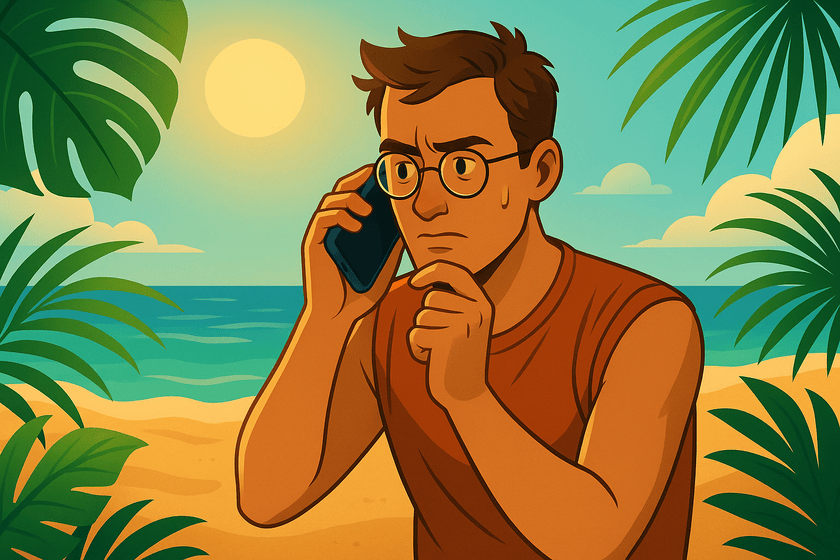

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

In [4]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

### 1. Przygotowanie zbioru jak w pierwszym zadaniu

In [5]:
titanic_df.drop(['Name', 'Ticket'], axis=1, inplace=True)

titanic_df['Cabin'] = titanic_df['Cabin'].str[0]

titanic_df = titanic_df.convert_dtypes()
titanic_df['Age'] = titanic_df['Age'].astype(pd.Int64Dtype())

age_distribution = titanic_df['Age'].value_counts(normalize=True)
age_values = age_distribution.index
age_probs = age_distribution.values
missing_age_vals = titanic_df['Age'].isna()
titanic_df.loc[missing_age_vals, 'Age'] = np.random.choice(age_values, size=missing_age_vals.sum(), p=age_probs)

fare_distribution = titanic_df['Fare'].round().value_counts(normalize=True)
fare_values = fare_distribution.index
fare_probs = fare_distribution.values
missing_fare_vals = titanic_df['Fare'].isna()
titanic_df.loc[missing_fare_vals, 'Fare'] = np.random.choice(fare_values, size=missing_fare_vals.sum(), p=fare_probs)

mode_embarked = titanic_df['Embarked'].mode()[0]
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(mode_embarked)

titanic_df['Cabin'] = titanic_df['Cabin'].fillna('Unknown')

new_column = pd.Series(data=titanic_df['Parch']+titanic_df['SibSp'], index=titanic_df.index, name='Family')
titanic_df = titanic_df.join(new_column)

is_child = titanic_df['Age'] <= 5
titanic_df['Child'] = 0
titanic_df.loc[is_child, 'Child'] = 1

titanic_df['Sex'] = titanic_df['Sex'].map({'female':0, 'male':1})

titanic_df['Embarked'] = titanic_df['Embarked'].map({'S':0, 'Q':1, 'C':2})

titanic_df['Cabin'] = titanic_df['Cabin'].map({'Unknown':0, 'T':0, 'G':1, 'F':2, 'E':3, 'D':4, 'C':5, 'B':6, 'A':7})

titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family,Child
PassengerId,,,,,,,,,,,
1,0,3,1,22,1,0,7.25,0,0,1,0
2,1,1,0,38,1,0,71.2833,5,2,1,0
3,1,3,0,26,0,0,7.925,0,0,0,0
4,1,1,0,35,1,0,53.1,5,0,1,0
5,0,3,1,35,0,0,8.05,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,1,27,0,0,13.0,0,0,0,0
888,1,1,0,19,0,0,30.0,6,0,0,0
889,0,3,0,24,1,2,23.45,0,0,3,0


### 2. Wnioski z pierwszego zadania
1. Wydaje się, że najbardziej wpływającymi na przeżywalność cechami były płeć oraz klasa. Za to wiek okazał się nie mieć dużego znaczenia co mnie zdziwiło.
2. Większość osób nie przeżyła (ok. 60%), więc możliwe że modele częściej niż powinny będą przewidywać śmierć
3. Chcemy przewidywać binarne Survived czyli użyjemy modeli do klasyfikacji

### Podział zbioru

In [6]:
X = titanic_df.drop(columns=['Survived'])
y = titanic_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Dummy Classifier

              precision    recall  f1-score   support

         0.0       0.60      0.61      0.60       105
         1.0       0.43      0.42      0.42        74

    accuracy                           0.53       179
   macro avg       0.51      0.51      0.51       179
weighted avg       0.53      0.53      0.53       179

[[64 41]
 [43 31]]


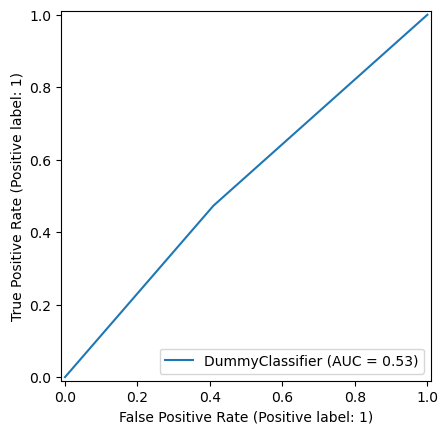

In [7]:
model = DummyClassifier(strategy = 'stratified')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
RocCurveDisplay.from_estimator(model, X_test, y_test)

### 4. KNN
Sprawdzę ilość sąsiadów i metrykę odległości

In [11]:
def n_vs_score_subplot(score_function, label):
    y1 = []
    y2 = []
    y3 = []

    for i in range(1, 21):
        model_1 = KNeighborsClassifier(n_neighbors=i, metric='cosine', weights='distance')
        model_1.fit(X_train, y_train)
        y_pred = model_1.predict(X_test)
        y1.append(score_function(y_test, y_pred))

        model_2 = KNeighborsClassifier(n_neighbors=i, metric='euclidean', weights='distance')
        model_2.fit(X_train, y_train)
        y_pred = model_2.predict(X_test)
        y2.append(score_function(y_test, y_pred))

        model_3 = KNeighborsClassifier(n_neighbors=i, metric='manhattan', weights='distance')
        model_3.fit(X_train, y_train)
        y_pred = model_3.predict(X_test)
        y3.append(score_function(y_test, y_pred))
        
    sns.lineplot(x=np.arange(1, 21, 1), y=y1, label='cosine')
    sns.lineplot(x=np.arange(1, 21, 1), y=y2, label='euclidean')
    sns.lineplot(x=np.arange(1, 21, 1), y=y3, label='manhattan')
    plt.title(f'Neighbours vs {label}')
    plt.xlabel('Number of Neighbours')
    plt.xticks(np.arange(1, 21, 1))
    plt.ylabel(label)
    plt.legend()

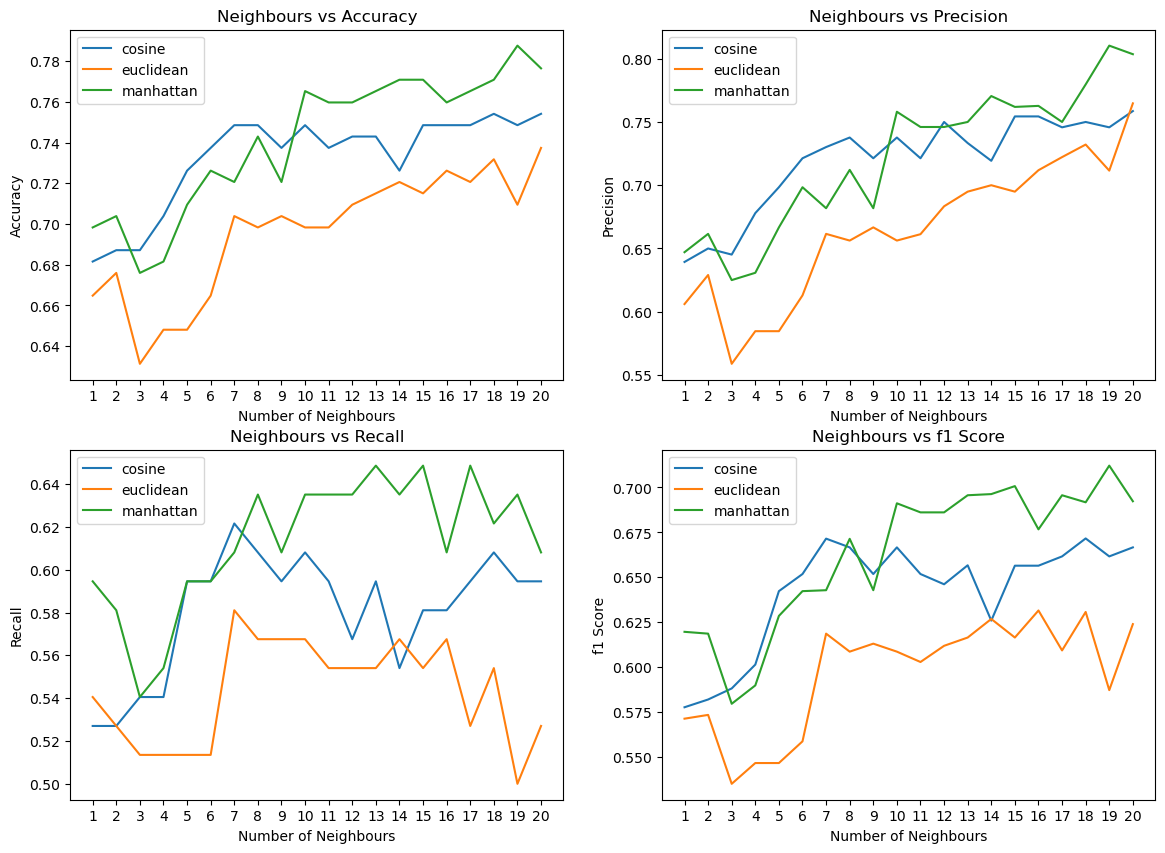

In [12]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
n_vs_score_subplot(accuracy_score, 'Accuracy')

plt.subplot(2, 2, 2)
n_vs_score_subplot(precision_score, 'Precision')

plt.subplot(2, 2, 3)
n_vs_score_subplot(recall_score, 'Recall')

plt.subplot(2, 2, 4)
n_vs_score_subplot(f1_score, 'f1 Score')

Na pierwszy rzut oka widać, że za mała ilość sąsiadów źle wpływa na wyniki. Po odpaleniu kilka razu zauważyłam, że metryka euklidesowa zwykle radziła sobie najgorzej. To czy lepiej rzadziła sobie cosinusowa czy manhattan, zmieniało się. Ok. 10 sąsiadów wydaje się dobrym wyborem.

              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81       105
         1.0       0.76      0.64      0.69        74

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.76      0.77      0.76       179

[[90 15]
 [27 47]]


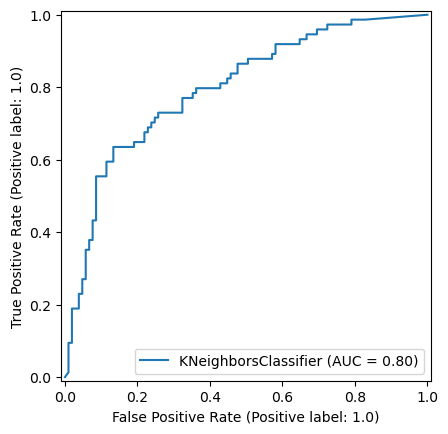

In [61]:
model = KNeighborsClassifier(n_neighbors=10, metric='manhattan', weights='distance')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
RocCurveDisplay.from_estimator(model, X_test, y_test)

Widać, że jest więcej false negatives niż false positives czego się spodziewałam, generalnie chyba ok

### 5. SVM
Postanowiłam wybrać kernel rbf i zbadać parametry C i gamma

In [16]:
C_range = np.logspace(1, 6, 6)
gamma_range = np.logspace(-6, -1, 6)

scores = np.ndarray((len(C_range), len(gamma_range)))

i=0
j=0
for C in C_range:
    for gamma in gamma_range:
        model = SVC(kernel='rbf', C=C, gamma=gamma)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # print(f"C: {C}, gamma: {gamma}")
        # print(roc_auc_score(y_test, y_pred))
        # print("")

        scores[i, j] = roc_auc_score(y_test, y_pred)
        j += 1
    i += 1
    j = 0

scores


array([[0.53101673, 0.60733591, 0.64034749, 0.69839125, 0.73661519,
        0.60823681],
       [0.60534106, 0.65585586, 0.77715573, 0.75688546, 0.72033462,
        0.60546976],
       [0.65585586, 0.77992278, 0.76563707, 0.80894466, 0.71081081,
        0.57490347],
       [0.77516088, 0.77039897, 0.76763192, 0.75611326, 0.72232947,
        0.54710425],
       [0.77039897, 0.78391248, 0.77239382, 0.75611326, 0.67824968,
        0.56936937],
       [0.78191763, 0.78867439, 0.75810811, 0.73185328, 0.61743887,
        0.55186615]])

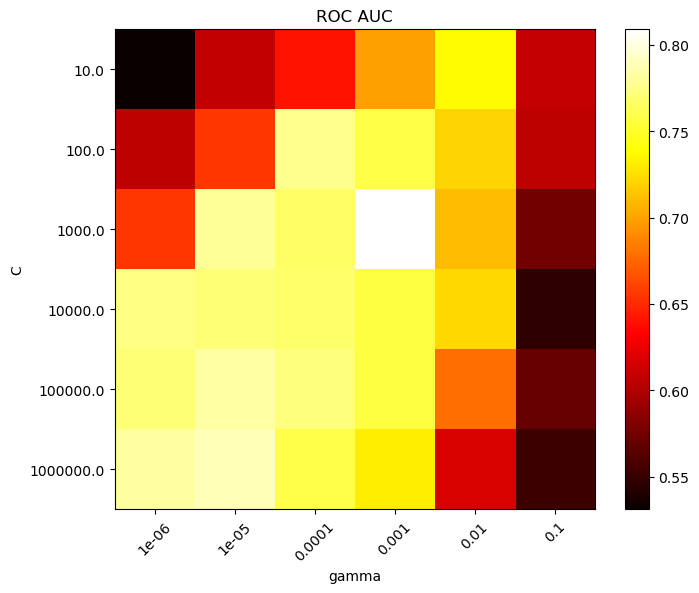

In [17]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("ROC AUC")
plt.show()

Najlepsze wyniki wychodzą w okolicy przekątnej i raczej w stronę lewego dolnego rogu

              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84       105
         1.0       0.78      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

[[89 16]
 [17 57]]


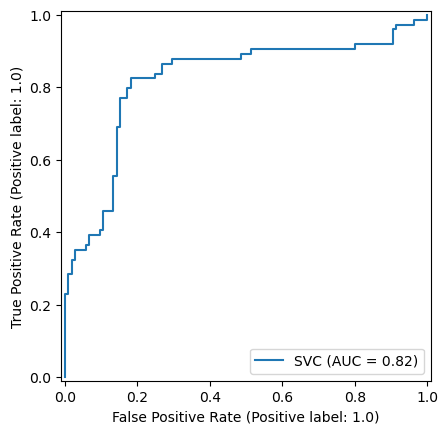

In [64]:
model = SVC(kernel='rbf', C=1000, gamma=0.001)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
RocCurveDisplay.from_estimator(model, X_test, y_test)

Wygląda na to, że poradził sobie trochę lepiej, głównie w mniejszej ilości false negatives

### 7. Czy ja bym przeżyła?!
Zakładam podróż z moją rodzinką, bilet 2 klasy i odpowiednią do niego cenę, przeciętną kabinę, najpopularniejszy port

In [25]:
titanic_df.loc[titanic_df.Pclass==2]['Fare'].median()

13.825

In [26]:
titanic_df['Embarked'].mode()[0]

0

In [27]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family,Child
PassengerId,,,,,,,,,,
1,3,1,22,1,0,7.25,0,0,1,0
2,1,0,38,1,0,71.2833,5,2,1,0
3,3,0,26,0,0,7.925,0,0,0,0
4,1,0,35,1,0,53.1,5,0,1,0
5,3,1,35,0,0,8.05,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
887,2,1,27,0,0,13.0,0,0,0,0
888,1,0,19,0,0,30.0,6,0,0,0
889,3,0,24,1,2,23.45,0,0,3,0


In [57]:
my_data = pd.DataFrame([[2, 0, 19, 2, 2, 14, 3, 0, 4, 0]], columns=X.columns)
my_data

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family,Child
0,2,0,19,2,2,14,3,0,4,0


In [58]:
model.predict(my_data)[0]

0.0

Nie przeżyłabym :(